In [1]:
from data import load_data_with_features
y_column, x_columns, ts, useless_rows = load_data_with_features(
    "real_counts.db", is_csv=False, detailed_seasonality=False, extra_features=False
)

In [2]:
ts.describe()

,t,count,hour_of_day,day_of_week,month_of_year
count,4.794000e+03,4794.000000,4794.000000,4794.000000,4794.0
mean,1.623776e+09,14.295160,13.833751,1.993951,6.0
std,5.119805e+05,12.975232,4.664959,1.603565,0.0
min,1.622805e+09,0.000000,0.000000,0.000000,6.0
25%,1.623258e+09,1.000000,11.000000,1.000000,6.0
50%,1.623791e+09,13.000000,14.000000,2.000000,6.0
75%,1.624287e+09,24.000000,17.000000,3.000000,6.0
max,1.624645e+09,64.000000,23.000000,6.000000,6.0


<AxesSubplot:xlabel='t'>

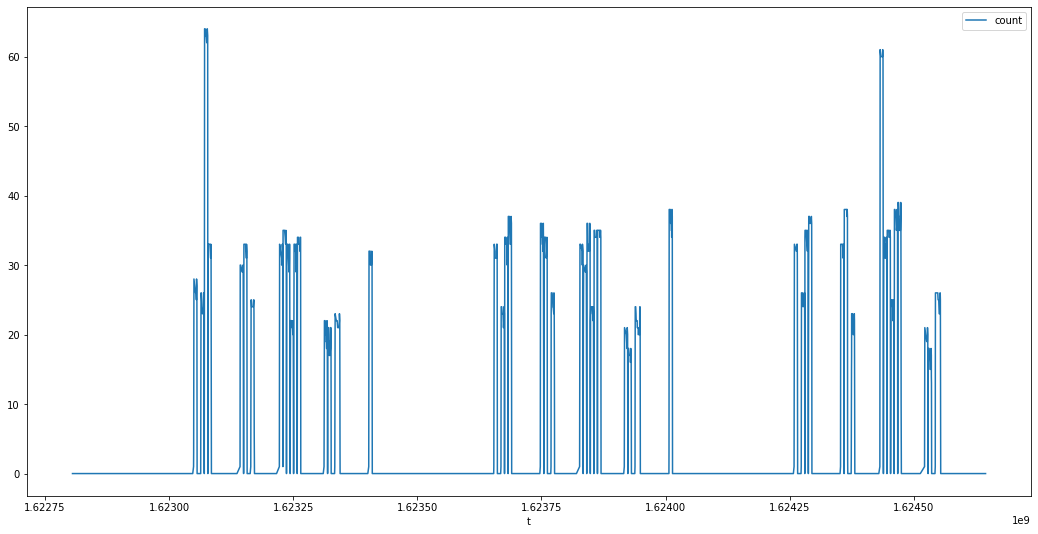

In [3]:
from data import TIME_COLUMN
ts.plot(x=TIME_COLUMN, y=y_column, figsize=(18, 9))

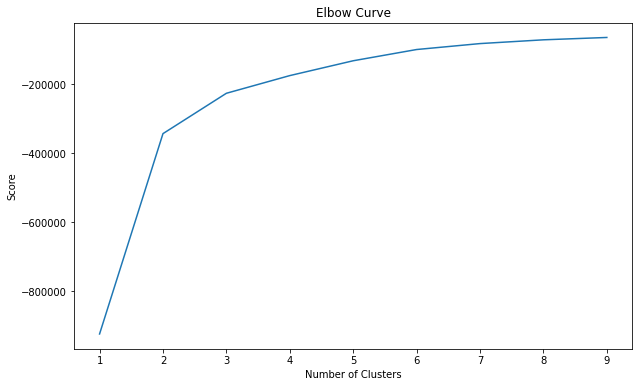

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
data = ts.loc[:, ts.columns != TIME_COLUMN]
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [5]:
import pandas as pd
import numpy as np
from data import DEFAULT_FLOAT_TYPE
km = kmeans[6]

def getDistanceByPoint(data: pd.DataFrame, model: KMeans) -> pd.Series:
    distance = pd.Series(index=range(len(data)), dtype=DEFAULT_FLOAT_TYPE)
    for i in range(len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance.iat[i] = np.linalg.norm(Xa - Xb)
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, km)
number_of_outliers = int(outliers_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min()

In [6]:
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
ts["anomaly1"] = pd.Series((distance >= threshold).values, index=ts.index, dtype=np.int64)
a = ts.loc[ts["anomaly1"] == 1, [TIME_COLUMN, y_column]]

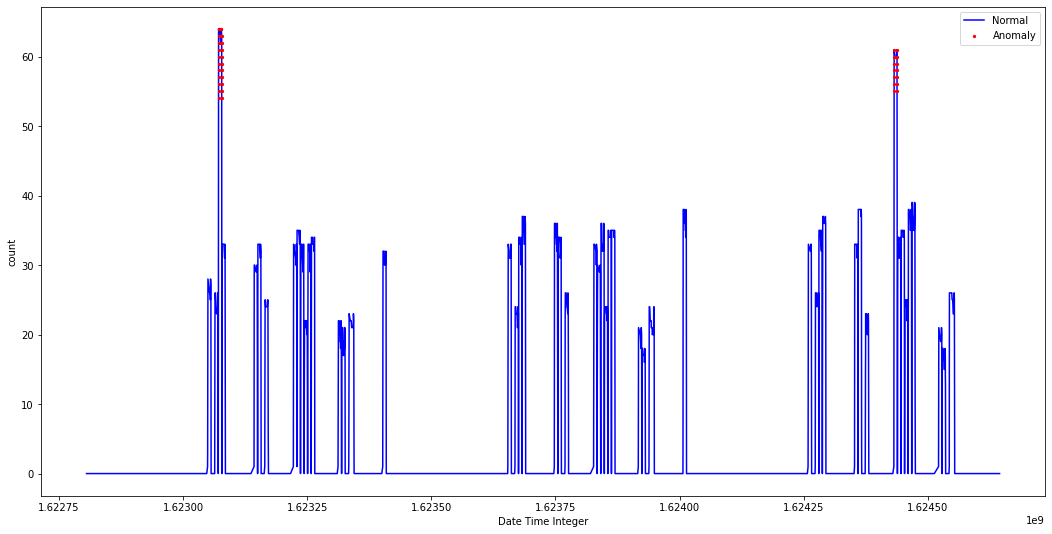

In [8]:
fig, ax = plt.subplots(figsize=(18,9))

start_t = ts.index[0]
end_t = ts.index[-1]
ax.plot(
    ts.loc[(ts.index >= start_t) & (ts.index <= end_t), TIME_COLUMN],
    ts.loc[(ts.index >= start_t) & (ts.index <= end_t), y_column],
    color="blue",
    label="Normal",
    zorder=5
)
ax.scatter(
    a.loc[(a.index >= start_t) & (a.index <= end_t), TIME_COLUMN],
    a.loc[(a.index >= start_t) & (a.index <= end_t), y_column],
    color="red",
    label="Anomaly",
    s=5,
    zorder=10
)
plt.xlabel("Date Time Integer")
plt.ylabel(y_column)
plt.legend()
plt.show()